# Modelling

Feature engineering, model training, tuning, selection and explanability.

# 0. Load Packages and Define Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import preprocess_df, clean_amenities

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.ensemble import StackingRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder, RobustScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display="diagram")

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from keras import backend
import shap
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def fit_and_score(model, X_train, X_test, y_train, y_test):
    
    model.fit(X_train, y_train)
    
    # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'],n_jobs=2, verbose=1, cv = 5) 
    
    # Test metrics
    pred_test= model.predict(X_test)
    test_MSE = mean_squared_error(y_test, pred_test)
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')
    print('Test R-sq', round(model.score(X_test, y_test),4))
    print('Test MSE:', round(test_MSE,4))
    
    return model

def grid_search_pipe(model, grid, X_train, y_train):
    
    search = GridSearchCV(model, grid, cv=5,n_jobs=2, scoring='r2', verbose=1)
    search.fit(X_train, y_train)
    
    print("Best params:\n{}".format(search.best_params_))
    print("Best score:\n{}".format(search.best_score_)) #Mean cross-validated score of the best_estimator
    
    return search

In [4]:
def check_impact(df):
        
    random_state = 1

    y_variable = ['price_log']
    to_drop = ['id', 'host_id', 'property_type', 'price', 'host_since', 'first_review', 'last_review']

    X = df.fillna(0).drop(y_variable + to_drop, axis = 1)
    y = df[y_variable[0]].ravel()

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

    # Get numeric and categorical columns
    num_cols = list(X.select_dtypes(include=np.number).columns)
    cat_cols = list(set(X.columns)-set(X[num_cols].columns))

    # Preprocess
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols ),
            ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
        ]
        , remainder='passthrough'
    )

    
    lgbm_best = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state,
                                               boosting_type = 'gbdt',
                                               colsample_bytree = 0.5,
                                               max_bin = 10,
                                               max_depth = 12,
                                               n_estimators = 350,
                                               num_leaves = 30,
                                               subsample = 0.50))
                   ])


    model = fit_and_score(model = lgbm_best, 
                                 X_train = X_train, 
                                 X_test = X_test,
                                 y_train = y_train,
                                 y_test = y_test)
    
    print('')
    print('Shape of X: {}'.format(np.shape(X)))
    

# 1. Load and Preprocess

In [5]:
data = pd.read_csv('data/listings.csv.gz')


<AxesSubplot:>

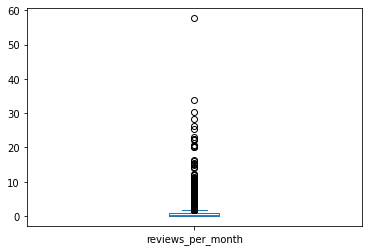

In [6]:
data['reviews_per_month'].plot(kind='box')

In [36]:
data['reviews_per_month'].describe()

count    48082.000000
mean         0.635780
std          1.037195
min          0.010000
25%          0.090000
50%          0.290000
75%          0.790000
max         57.660000
Name: reviews_per_month, dtype: float64

In [7]:
df = preprocess_df(data = data, verbose = True)

bedrooms: 331 values above cutoff, value_cutoff = 4.639999999999418
minimum_nights: 134 values above cutoff, value_cutoff = 90.0
maximum_nights: 12 values above cutoff, value_cutoff = 1125.0
minimum_nights_avg_ntm: 167 values above cutoff, value_cutoff = 90.0


In [8]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable', 'reviews_per_month',
       'bathroom_num', 'bathroom_sharing', 'price_log'],
      dtype='object')

In [9]:
df = clean_amenities(data = df, num_amenities =80, verbose = True)

In [10]:
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_outdoor dining area,amenities_children’s books and toys,amenities_cleaning before checkout,amenities_clothing storage,amenities_clothing storage: closet,amenities_mini fridge,amenities_private fenced garden or backyard,amenities_building staff,amenities_paid street parking off premises,amenities_nespresso machine
1,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,0,0,0,0,0,0,0,0,0
4,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,0,0,0,0,0,0,0,0,0
9,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,0,1,0,0,0,1,0,0,0
11,38995,167281,2020-02-21,0,1.0,1,1,0.0,51.47860,-0.06114,...,0,0,0,0,0,0,0,0,0,0
14,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df['room_type'].value_counts()

Entire home/apt    20083
Private room       12646
Shared room          142
Hotel room           139
Name: room_type, dtype: int64

# 1. Feature Engineering

## Host Duration

In [12]:
# Last scraped date = 2021-12-07 (7th Dec)
df['host_duration'] = (pd.to_datetime('2021-12-10') - df['host_since']).dt.days

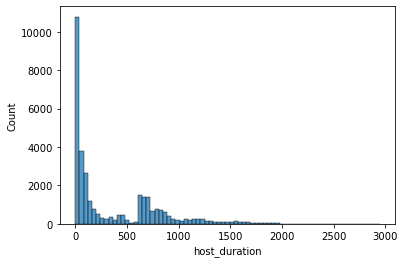

In [13]:
sns.histplot(df['host_duration'])
plt.show()

In [14]:
check_impact(df=df)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    5.6s finished


Train R-sq 0.869
Train MSE: 0.0811

CV R-sq 0.7812
CV MSE: 0.1355

Test R-sq 0.7998
Test MSE: 0.1237

Shape of X: (33010, 114)


## Managed_property

In [15]:
# Understand how many properties are potentially property managed

percentiles=[0.80,0.85,0.90,0.95]
percentile_rooms=[]
room_above=[]

for p in percentiles:
   percentile_rooms.append(df.host_id.value_counts().quantile(p))

print('Understand managed property percentiles beyond P75\n')
print(pd.DataFrame({'percentile':percentiles,'rooms_threshold':percentile_rooms}))

property_count=pd.DataFrame(df.groupby(['host_id'])['host_id'].count())
property_count.columns=['properties']
property_count

Understand managed property percentiles beyond P75

   percentile  rooms_threshold
0        0.80              1.0
1        0.85              2.0
2        0.90              2.0
3        0.95              3.0


,properties
host_id,
4775,7
5653,1
6774,3
9323,1
10657,2
...,...
433334823,1
433435234,2
433572694,1


In [16]:
property_count['prop_managed']=property_count['properties'].map(lambda x: 1 if x>=percentile_rooms[3] else 0)
df=pd.merge(df,property_count,on='host_id',how='inner')
df.prop_managed.value_counts()

0    22496
1    10514
Name: prop_managed, dtype: int64

In [17]:
check_impact(df=df)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    3.1s finished


Train R-sq 0.8738
Train MSE: 0.0783

CV R-sq 0.7881
CV MSE: 0.1314

Test R-sq 0.7916
Test MSE: 0.1279

Shape of X: (33010, 116)


## Occupancy Rate

In [18]:
cols=['availability_30','availability_60', 'availability_90','availability_365']
df[cols].describe()

,availability_30,availability_60,availability_90,availability_365
count,33010.000000,33010.000000,33010.000000,33010.000000
mean,6.882187,18.561527,31.615177,121.371191
std,9.251464,20.881292,33.341793,134.103803
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,7.000000,17.000000,66.000000
75%,12.000000,37.000000,65.000000,248.000000
max,30.000000,60.000000,90.000000,365.000000


In [19]:
df['occ_30D']=1-round(df.availability_30/30,2)
df['occ_6090D']=((1-round(df.availability_60/60,2))+(1-round(df.availability_90/90,2)))/2
df['occ_365']=1-round(df.availability_365/365,2)

df=df.drop(cols,axis=1) # do not drop

In [20]:
df.columns

Index(['id', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'amenities_private fenced garden or backyard',
       'amenities_building staff',
       'amenities_paid street parking off premises',
       'amenities_nespresso machine', 'host_duration', 'properties',
       'prop_managed', 'occ_30D', 'occ_6090D', 'occ_365'],
      dtype='object', length=123)

In [21]:
check_impact(df=df)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    3.1s finished


Train R-sq 0.8711
Train MSE: 0.08

CV R-sq 0.7865
CV MSE: 0.1325

Test R-sq 0.7866
Test MSE: 0.1309

Shape of X: (33010, 115)


## Location Variables

In [22]:
# Load computed location features
location_features = ['station', 'station_dist','walking_distance']
df = df.merge(pd.read_csv('computed_features/london_nearest_tube.csv')[['id']+location_features],left_on='id', right_on='id',how='left')
df.head()

,id,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,amenities_nespresso machine,host_duration,properties,prop_managed,occ_30D,occ_6090D,occ_365,station,station_dist,walking_distance
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0,634,1,0,1.0,1.000,0.99,South Kensington,805.406363,0.0
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,0,635,3,1,1.0,1.000,1.00,Brent Cross,302.665825,1.0
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,0,692,3,1,0.9,0.960,0.99,Brent Cross,346.564965,1.0
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,0,630,3,1,1.0,1.000,1.00,Brent Cross,361.025714,1.0
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,0,485,1,0,0.8,0.335,0.07,Shepherds Bush Market,449.743591,3.0


## Sentiment

In [23]:
import pandas as pd
df_sentiment = pd.read_csv('computed_features/nc_eng_with_sent.csv')

df=pd.merge(df,df_sentiment,left_on='id', right_on='listing_id',how='left')
df = df.drop(['listing_id'], axis = 1)
df = df.fillna(df.mean())
df.head()

,id_x,host_id,host_since,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,latitude,longitude,...,walking_distance,Unnamed: 0,id_y,reviewer_id,comments_len,key_reviewer,negative,neutral,positive,compound
0,15400,60302,2020-03-16,0,1.0,1,1,0.0,51.48780,-0.16813,...,0.0,1.0,8.029375e+07,2.695406e+07,78.062500,0.075000,0.016000,0.682400,0.301550,0.900261
1,25123,103583,2020-03-15,0,3.0,1,1,0.0,51.57438,-0.21081,...,1.0,3.0,8.898858e+07,3.434179e+07,61.970588,0.127451,0.011020,0.607324,0.381667,0.941062
2,41311,103583,2020-01-18,0,3.0,1,1,0.0,51.57400,-0.21058,...,1.0,10.0,1.066726e+08,3.536433e+07,71.552239,0.074627,0.007433,0.627463,0.365134,0.961803
3,19516454,103583,2020-03-20,0,3.0,1,1,0.0,51.57466,-0.20916,...,1.0,16621.0,4.596262e+08,1.034197e+08,44.500000,0.136364,0.003682,0.558909,0.437409,0.953786
4,38610,165579,2020-08-12,1,2.0,1,1,0.0,51.50701,-0.23362,...,3.0,7.0,3.235218e+08,8.901368e+07,86.068966,0.000000,0.007931,0.707483,0.284621,0.927310


# 2. Feature selection

In [24]:
from lightgbm import LGBMRegressor
from lightgbm import plot_importance
from sklearn.preprocessing import LabelEncoder


def regression_scores(model, X_train, X_test, y_train, y_test):
    
     # Train metrics
    pred_train= model.predict(X_train)
    train_MSE = mean_squared_error(y_train, pred_train)
    
    # Cross validated metrics
    cv_score = cross_validate(model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5) 
    
    
    print('Train R-sq', round(model.score(X_train, y_train),4))
    print('Train MSE:', round(train_MSE,4))
    print('')
    print('CV R-sq', round(np.mean(cv_score['test_r2']),4))
    print('CV MSE:', round(-np.mean(cv_score['test_neg_mean_squared_error']),4))
    print('')

def run_model(X, y):
    
    random_state = 42
    
    # Automatic label encoding
    le = LabelEncoder()
    for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = le.fit_transform(X[column_name])
        else:
            pass

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    
    # Train Model
    rf = RandomForestRegressor(n_jobs = -1, random_state = random_state)
    
    # Fit Model
    rf.fit(X_train, y_train)

    # Score model on test set
    regression_scores(rf, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [25]:
## LGBMReressor

from numpy import sort
from sklearn.feature_selection import SelectFromModel
#Get a function to generally see feature importance
def run_lgbm(X,y):
    random_state = 42
    
     # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    lgbm = LGBMRegressor(n_jobs=-1,random_state=random_state)
    lgbm.fit(X_train,y_train)
    print('Scores run on full number of features')
    regression_scores(lgbm, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

    # plot feature importance
    plot_importance(lgbm, importance_type="gain")
    plt.show()

    # Fit model using each importance as a threshold
    thresholds = sort(lgbm.feature_importances_) # sort the importance score

    # select feaures by using importance score as threshold
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(lgbm, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = LGBMRegressor(n_jobs=-1, random_state = 42)
        selection_model.fit(select_X_train, y_train)
        # eval model
        cv_score = cross_validate(selection_model, select_X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5)
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]

        print("Thresh=%.3f, n=%d, CV MSE: %.2f" % (thresh, select_X_train.shape[1], round(-np.mean(cv_score['test_neg_mean_squared_error']),4)))
    
    return selection

In [26]:
## LGBMReressor
from lightgbm import LGBMRegressor
from lightgbm import plot_importance

from numpy import sort
from sklearn.feature_selection import SelectFromModel

#Re-write function to accept threshold value and also output the test MSE on the selected subset
def thresh_run_lgbm(X,y,thresh):
    random_state = 42
    
     # Automatic label encoding
    le = LabelEncoder()
    for column_name in X.columns:
        if X[column_name].dtype == object:
            X[column_name] = le.fit_transform(X[column_name])
        else:
            pass
        
     # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    lgbm = LGBMRegressor(n_jobs=-1,random_state=random_state)
    lgbm.fit(X_train,y_train)
    

    # Fit model using each importance as a threshold
    thresholds = sort(lgbm.feature_importances_) # sort the importance score

    # select features using threshold
    selection = SelectFromModel(lgbm, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = LGBMRegressor(n_jobs=-1, random_state = 42)
    selection_model.fit(select_X_train, y_train)
    # eval model on cv
    cv_score = cross_validate(selection_model, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'], verbose=0, cv = 5)
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
   
   # CV_MSE = mean_squared_error(y_test, cv_score)
    
    print('Score from selected subset of features')
    #Score of subset features (not all features)
    regression_scores(selection_model, X_train = select_X_train, X_test = select_X_test, y_train = y_train, y_test = y_test)
    
    print("Thresh=%.3f, n=%d, CV:%.2f" % (thresh, select_X_train.shape[1],round(-np.mean(cv_score['test_neg_mean_squared_error']),4)))
    
   
    ##carry on from selection 
    include = selection.get_support()
    headers = X_all.columns

    fs = pd.DataFrame({'cols':headers,'include':include})
    filters = (fs.include==True)
    selected_col = fs[filters].cols.tolist()
    
    return selected_col

In [27]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [28]:
drop_cols=['id_x','host_id','host_has_profile_pic','price','price_log','id_y','reviewer_id','host_since','key_reviewer','first_review','last_review']
X_all=df.drop(drop_cols,axis=1)
y_all=df['price_log']

In [29]:
lgbm_col = thresh_run_lgbm(X_all,y_all,5)

Score from selected subset of features
Train R-sq 0.8357
Train MSE: 0.1012

CV R-sq 0.7809
CV MSE: 0.1348

Thresh=5.000, n=65, CV:0.14


In [30]:
fs_cols=lgbm_col
df_fs= df[fs_cols]
df.columns

Index(['id_x', 'host_id', 'host_since', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude',
       ...
       'walking_distance', 'Unnamed0', 'id_y', 'reviewer_id', 'comments_len',
       'key_reviewer', 'negative', 'neutral', 'positive', 'compound'],
      dtype='object', length=135)

# 3. Models

In [31]:
# Format columns
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [32]:
df.columns.tolist()

['id_x',
 'host_id',
 'host_since',
 'host_is_superhost',
 'host_total_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'has_availability',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'instant_bookable',
 'reviews_per_month',
 'bathroom_num',
 'bathroom_sharing',
 'price_log',
 'amenities_wifi',
 'amenities_essentials',
 'amenities_smokealarm',
 'amenities_heating',
 'amenities_kitchen',
 'amenities_hangers',
 'amenities_longtermstaysallowed',
 'amenities_iron',
 'amenities_washer',
 'amenities

In [33]:
sentiment_features = [   'comments_len',
                         'neutral',
                         'negative',
                         'positive']

features_selected = ['host_total_listings_count',
                         'neighbourhood_group_cleansed',
                         'latitude',
                         'longitude',
                         'room_type',
                         'accommodates',
                         'bedrooms',
                         'minimum_nights',
                         'maximum_nights',
                         'minimum_nights_avg_ntm',
                         'maximum_nights_avg_ntm',
                         'number_of_reviews',
                         'number_of_reviews_ltm',
                         'number_of_reviews_l30d',
                         'review_scores_rating',
                         'review_scores_accuracy',
                         'review_scores_cleanliness',
                         'review_scores_checkin',
                         'review_scores_communication',
                         'review_scores_location',
                         'review_scores_value',
                         'reviews_per_month',
                         'bathroom_num',
                         'bathroom_sharing',
                        'amenities_wifi',
                        'amenities_essentials',
                        'amenities_smokealarm',
                        'amenities_heating',
                        'amenities_kitchen',
                        'amenities_hangers',
                        'amenities_longtermstaysallowed',
                        'amenities_iron',
                        'amenities_washer',
                        'amenities_hairdryer',
                        'amenities_hotwater',
                        'amenities_shampoo',
                        'amenities_carbonmonoxidealarm',
                        'amenities_dedicatedworkspace',
                        'amenities_dishesandsilverware',
                        'amenities_cookingbasics',
                        'amenities_refrigerator',
                        'amenities_bedlinens',
                        'amenities_tv',
                        'amenities_microwave',
                        'amenities_oven',
                        'amenities_stove',
                        'amenities_dryer',
                        'amenities_firstaidkit',
                        'amenities_fireextinguisher',
                        'amenities_coffeemaker',
                        'amenities_dishwasher',
                        'amenities_privateentrance',
                        'amenities_extrapillowsandblankets',
                        'amenities_luggagedropoffallowed',
                        'amenities_hostgreetsyou',
                        'amenities_lockbox',
                        'amenities_bathtub',
                        'amenities_elevator',
                        'amenities_freeparkingonpremises',
                        'amenities_showergel',
                        'amenities_paidparkingoffpremises',
                        'amenities_hotwaterkettle',
                        'amenities_backyard',
                        'amenities_freestreetparking',
                        'amenities_lockonbedroomdoor',
                        'amenities_cabletv',
                        'amenities_patioorbalcony',
                        'amenities_freezer',
                        'amenities_tvwithstandardcable',
                        'amenities_cleaningproducts',
                        'amenities_toaster',
                        'amenities_diningtable',
                        'amenities_wineglasses',
                        'amenities_roomdarkeningshades',
                        'amenities_bodysoap',
                        'amenities_breakfast',
                        'amenities_dryingrackforclothing',
                        'amenities_singlelevelhome',
                        'amenities_securitycamerasonproperty',
                        'amenities_conditioner',
                        'amenities_indoorfireplace',
                        'amenities_portablefans',
                        'amenities_ethernetconnection',
                        'amenities_outdoorfurniture',
                        'amenities_laundromatnearby',
                        'amenities_packnplaytravelcrib',
                        'amenities_crib',
                        'amenities_airconditioning',
                        'amenities_highchair',
                        'amenities_bakingsheet',
                        'amenities_bbqgrill',
                        'amenities_paidparkingonpremises',
                        'amenities_privatepatioorbalcony',
                        'amenities_centralheating',
                        'amenities_outdoordiningarea',
                        'amenities_childrensbooksandtoys',
                        'amenities_cleaningbeforecheckout',
                        'amenities_clothingstorage',
                        'amenities_clothingstoragecloset',
                        'amenities_minifridge',
                        'amenities_privatefencedgardenorbackyard',
                        'amenities_buildingstaff',
                        'amenities_paidstreetparkingoffpremises',
                        'amenities_nespressomachine',
                         'host_duration',
                         'properties',
                         'occ_30D',
                         'occ_6090D',
                         'occ_365'] + location_features + sentiment_features

In [34]:
random_state = 99

y_variable = ['price_log']

# Set X and y features
X = df[features_selected]
y = df[y_variable[0]].ravel()

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size =0.2, random_state = random_state)

# Numercial and categorical columns to process
num_cols = list(X.select_dtypes(include=np.number).columns)
cat_cols = list(set(X.columns)-set(X[num_cols].columns))

print('X shape: {}'.format(np.shape(X)))
print('y shape: {}'.format(np.shape(y)))
print(cat_cols)

X shape: (33010, 116)
y shape: (33010,)
['room_type', 'station', 'bathroom_sharing']


In [35]:
# Preprocess
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols ),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
    ]
    , remainder='passthrough'
)

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['host_total_listings_count',
                                  'neighbourhood_group_cleansed', 'latitude',
                                  'longitude', 'accommodates', 'bedrooms',
                                  'minimum_nights', 'maximum_nights',
                                  'minimum_nights_avg_ntm',
                                  'maximum_nights_avg_ntm', 'number_of_reviews',
                                  'number_of_reviews_ltm',
                                  'number_of_reviews_l30d',
                                  'review_...
                                  'review_scores_value', 'reviews_per_month',
                                  'bathroom_num', 'amenities_wifi',
                                  'amenities_essentials',
                                  'amenities_smokealarm', 'amenities_heating',
                                  'amenities_kitchen', 'amenities_hangers',
                                  'amenities_longtermstaysallowed',
                                  'amenities_iron', ...]),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['room_type', 'station', 'bathroom_sharing'])])

## XGB Regressor

### Tuning XGB

RandomizedSearch then GridSearch

In [115]:
xgb_pipe = Pipeline([('preprocess', preprocessor),
                    ('regressor', XGBRegressor(random_state = random_state,
                                              use_label_encoder=False))])

random_grid = {
    'preprocess__num':[StandardScaler(), RobustScaler(), QuantileTransformer()],
    "regressor__n_estimators": range(50, 500, 50),
    "regressor__max_depth": range(2,20,2),
    'regressor__subsample': np.linspace(0.3, 1, 10),
    'regressor__colsample_bytree': np.linspace(0.2, 1, 5),
    'regressor__reg_lambda': np.linspace(0, 5, 11),
    'regressor__reg_alpha': np.linspace(0, 5, 11),
    'regressor__gamma': np.linspace(0, 5, 5)
}

rsearch_xgb = RandomizedSearchCV(xgb_pipe, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
rsearch_xgb.fit(X_train, y_train)

print("Best params:\n{}".format(rsearch_xgb.best_params_))
print("Best score:\n{}".format(rsearch_xgb.best_score_)) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  3.9min finished


Best params:
{'regressor__subsample': 0.9222222222222223, 'regressor__reg_lambda': 1.0, 'regressor__reg_alpha': 4.5, 'regressor__n_estimators': 200, 'regressor__max_depth': 8, 'regressor__gamma': 0.0, 'regressor__colsample_bytree': 0.2, 'preprocess__num': QuantileTransformer()}
Best score:
0.7805279285130288


In [116]:
grid = {
    'preprocess__num':[RobustScaler()], # two different pipelines
    "regressor__n_estimators": [350,400,450],
    "regressor__max_depth": [6,8,10],
    'regressor__subsample': [0.9],
    'regressor__colsample_bytree': [0.6],
    'regressor__reg_lambda': [1,2,3],
    'regressor__reg_alpha': [2,3.5,4.5],
    'regressor__gamma': [2,3.75]
}

gsearch_xgb = grid_search_pipe(xgb_pipe, grid, X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 13.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 37.5min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 70.7min
[Parallel(n_jobs=2)]: Done 810 out of 810 | elapsed: 72.6min finished


Best params:
{'preprocess__num': RobustScaler(), 'regressor__colsample_bytree': 0.6, 'regressor__gamma': 2, 'regressor__max_depth': 8, 'regressor__n_estimators': 450, 'regressor__reg_alpha': 2, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.9}
Best score:
0.7806830585518298


### XGB Best

In [40]:
# Preprocess
preprocessor_xgb = ColumnTransformer(transformers=[('num', RobustScaler(), num_cols ),
                                                   ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
                                                  ], remainder='passthrough')

xgb_best = Pipeline([('preprocess', preprocessor_xgb),
                    ('regressor', XGBRegressor(random_state = random_state,
                                                use_label_encoder=False,
                                                subsample = 0.9,
                                                reg_alpha = 2,
                                                n_estimators = 450, 
                                                max_depth = 8, 
                                                gamma = 2,
                                                colsample_bytree = 0.6
                                                ))
                                            ])

xgb_model = fit_and_score(model = xgb_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:   30.1s finished


Train R-sq 0.8496
Train MSE: 0.0927

CV R-sq 0.7721
CV MSE: 0.1404

Test R-sq 0.795
Test MSE: 0.1292


## LGBM Regressor

### Tuning LGBM

In [119]:
lgb_pipe = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state))])
                    
random_grid = {'preprocess__num':[StandardScaler(),RobustScaler(), QuantileTransformer()],
                'regressor__boosting_type': ['gbdt','dart','goss'],
                'regressor__n_estimators': range(50, 500, 50),
                'regressor__max_bin':range(2, 20, 2),
                'regressor__num_leaves':range(10, 200, 10),
                'regressor__max_depth': np.arange(2,20,2).tolist(),
                'regressor__colsample_bytree' : np.linspace(0.2, 1, 5),
                'regressor__subsample' : np.linspace(0.3, 1, 10)}


rsearch_lgb = RandomizedSearchCV(lgb_pipe, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
rsearch_lgb.fit(X_train, y_train)

print("Best params:\n{}".format(rsearch_lgb.best_params_))
print("Best score:\n{}".format(rsearch_lgb.best_score_)) 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   52.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.6min finished


Best params:
{'regressor__subsample': 1.0, 'regressor__num_leaves': 120, 'regressor__n_estimators': 450, 'regressor__max_depth': 6, 'regressor__max_bin': 18, 'regressor__colsample_bytree': 0.2, 'regressor__boosting_type': 'gbdt', 'preprocess__num': StandardScaler()}
Best score:
0.7899872328550694


In [120]:

grid= {'preprocess__num':[StandardScaler()],
         'regressor__boosting_type': ['gbdt'],
         'regressor__n_estimators': [250,300,350],
         'regressor__max_bin':[10],
         'regressor__num_leaves': [25,30,35],
         'regressor__max_depth': [12,14,16],
         'regressor__colsample_bytree' : [0.3,0.4,0.5],
         'regressor__subsample' : [0.50,0.55,0.60]}

gsearch_lgb = grid_search_pipe(lgb_pipe, grid, X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   26.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  9.0min
[Parallel(n_jobs=2)]: Done 1215 out of 1215 | elapsed: 13.6min finished


Best params:
{'preprocess__num': StandardScaler(), 'regressor__boosting_type': 'gbdt', 'regressor__colsample_bytree': 0.4, 'regressor__max_bin': 10, 'regressor__max_depth': 12, 'regressor__n_estimators': 350, 'regressor__num_leaves': 35, 'regressor__subsample': 0.5}
Best score:
0.7864854102142951


### Best LGBM

In [39]:

lgbm_best = Pipeline([('preprocess', preprocessor),
                    ('regressor', LGBMRegressor(random_state = random_state,
                                               boosting_type = 'gbdt',
                                               colsample_bytree = 0.4,
                                               max_bin = 10,
                                               max_depth = 12,
                                               n_estimators = 350,
                                               num_leaves = 35,
                                               subsample = 0.50))
                   ])
        
lgb_model_tuned = fit_and_score(model = lgbm_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    4.0s finished


Train R-sq 0.8718
Train MSE: 0.079

CV R-sq 0.7837
CV MSE: 0.1333

Test R-sq 0.7988
Test MSE: 0.1268


## Random Forest Regressor

### Tuning RFR

In [123]:
rf_pipe= Pipeline([('preprocess', preprocessor),
                    ('regressor', RandomForestRegressor(random_state = random_state))])

random_grid = {'preprocess__num':[StandardScaler(),RobustScaler(), QuantileTransformer()],
               'regressor__max_features':['auto','sqrt','log2'],
                'regressor__n_estimators': range(100,500,50),
                'regressor__bootstrap': [True,False],
                'regressor__oob_score':[True,False],
                'regressor__max_depth': range(2, 20, 2),
                'regressor__ccp_alpha' : np.arange(0.01, 0.30,0.02).tolist(),
              'regressor__min_samples_split' : range(1,5,1)}


rsearch_rf = RandomizedSearchCV(rf_pipe, random_grid, cv=5,n_jobs=2, scoring='r2', n_iter = 100, verbose=1)
rsearch_rf.fit(X_train, y_train)

print("Best params:\n{}".format(rsearch_rf.best_params_))
print("Best score:\n{}".format(rsearch_rf.best_score_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 16.8min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 79.8min finished


Best params:
{'regressor__oob_score': False, 'regressor__n_estimators': 400, 'regressor__min_samples_split': 4, 'regressor__max_features': 'auto', 'regressor__max_depth': 12, 'regressor__ccp_alpha': 0.03, 'regressor__bootstrap': False, 'preprocess__num': RobustScaler()}
Best score:
0.4628498017499387


In [124]:


grid = {'preprocess__num':[RobustScaler()],
        'regressor__max_features':['log2'],
        'regressor__n_estimators': [200, 250, 300, 350],
        'regressor__bootstrap': [True],
        'regressor__oob_score':[False],
        'regressor__max_depth': [14, 18, 22],
        'regressor__ccp_alpha' : [0.0, 0.01, 0.05],
        'regressor__min_samples_split' : [2, 3, 4]}

gsearch_rf = grid_search_pipe(rf_pipe, grid, X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 26.5min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 61.3min
[Parallel(n_jobs=2)]: Done 540 out of 540 | elapsed: 81.2min finished


Best params:
{'preprocess__num': RobustScaler(), 'regressor__bootstrap': True, 'regressor__ccp_alpha': 0.0, 'regressor__max_depth': 22, 'regressor__max_features': 'log2', 'regressor__min_samples_split': 2, 'regressor__n_estimators': 250, 'regressor__oob_score': False}
Best score:
0.6498214880795379


### Best RFR

In [38]:
preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), num_cols),
        ("cat", Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
    ]
    , remainder='passthrough'
)

rf_best = Pipeline([('preprocess', preprocessor_rf), # try with robust scaler
                    ('regressor', RandomForestRegressor(random_state = random_state,
                                                        max_features = 'log2',
                                                       n_estimators = 250,
                                                       bootstrap = True,
                                                       oob_score = False,
                                                       max_depth = 22,
                                                       ccp_alpha = 0.0,
                                                       min_samples_split = 2
                                                       )) 
                   ])

rf_model_tuned = fit_and_score(model = rf_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.4min finished


Train R-sq 0.8076
Train MSE: 0.1186

CV R-sq 0.6441
CV MSE: 0.2193

Test R-sq 0.6548
Test MSE: 0.2176


## Stacking Regressor

In [41]:
estimators = [
    ("XGBoost Classifier", xgb_best),
    ("LGBM Classifier", lgbm_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor = StackingRegressor(estimators=estimators, 
                                         final_estimator=LGBMRegressor(random_state=random_state))
stacking_regressor

StackingRegressor(estimators=[('XGBoost Classifier',
                               Pipeline(steps=[('preprocess',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('num',
                                                                                 RobustScaler(),
                                                                                 ['host_total_listings_count',
                                                                                  'neighbourhood_group_cleansed',
                                                                                  'latitude',
                                                                                  'longitude',
                                                                                  'accommodates',
                                                                                  'bedrooms',
                                                                                  'minimum_nights',
                                                                                  'maximum_nights',
                                                                                  'minimum_nights_avg_ntm',
                                                                                  'maximum_nights_avg_ntm...
                                                                                  'amenities_kitchen',
                                                                                  'amenities_hangers',
                                                                                  'amenities_longtermstaysallowed',
                                                                                  'amenities_iron', ...]),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('ohe',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['station',
                                                                                  'bathroom_sharing',
                                                                                  'room_type'])])),
                                               ('regressor',
                                                RandomForestRegressor(max_depth=22,
                                                                      max_features='log2',
                                                                      n_estimators=250,
                                                                      random_state=99))]))],
                  final_estimator=LGBMRegressor(random_state=99))

In [42]:
stacking_regressor_base = fit_and_score(model = stacking_regressor, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


### Stacking L1 Tuning

GridSearch only

In [128]:
# Tune LightGBM at Level 1
grid = {'final_estimator__n_estimators': [50, 100, 150, 200, 250],
               'final_estimator__max_depth': [2, 4, 6, 8, 10]}

search = grid_search_pipe(model = stacking_regressor, 
                            grid = grid, 
                            X_train = X_train, 
                            y_train = y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


### Best Stacker

In [ ]:
estimators = [
    ("LGBM Classifier", lgbm_best),
    ("XGBoost Classifier", xgb_best),
    ("Random Forest Classifier", rf_best)
]

stacking_regressor_best = StackingRegressor(estimators=estimators, final_estimator=LGBMRegressor(random_state=random_state, max_depth = 4, n_estimators = 50))
stacking_regressor_best

StackingRegressor(estimators=[('LGBM Classifier',
                               Pipeline(steps=[('preprocess',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('num',
                                                                                 StandardScaler(),
                                                                                 ['host_total_listings_count',
                                                                                  'latitude',
                                                                                  'longitude',
                                                                                  'accommodates',
                                                                                  'bedrooms',
                                                                                  'minimum_nights',
                                                                                  'maximum_nights',
                                                                                  'minimum_nights_avg_ntm',
                                                                                  'maximum_nights_avg_ntm',
                                                                                  'number_of_reviews',
                                                                                  'number_of...
                                                                                  'amenities_dishesandsilverware', ...]),
                                                                                ('cat',
                                                                                 Pipeline(steps=[('ohe',
                                                                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                                                                 ['neighbourhood_group_cleansed',
                                                                                  'bathroom_sharing',
                                                                                  'room_type'])])),
                                               ('regressor',
                                                RandomForestRegressor(bootstrap=False,
                                                                      max_depth=22,
                                                                      max_features='sqrt',
                                                                      n_estimators=450,
                                                                      random_state=12))]))],
                  final_estimator=LGBMRegressor(max_depth=4, n_estimators=50,
                                                random_state=12))

In [ ]:
stacking_regressor_best = fit_and_score(model = stacking_regressor_best, 
                         X_train = X_train, 
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

Train R-sq 0.9527
Train MSE: 0.0311

CV R-sq 0.8407
CV MSE: 0.1048

Test R-sq 0.8577
Test MSE: 0.0967


## Neural Network

In [ ]:
X_train_trfm = X_train.drop(['station'],axis=1)
X_test_trfm = X_test.drop(['station'],axis=1)

X_train_trfm = pd.get_dummies(X_train_trfm, columns=['bathroom_sharing', 'room_type'])
X_test_trfm = pd.get_dummies(X_test_trfm, columns=['bathroom_sharing', 'room_type'])

cols = X_train_trfm.columns

stdscaler = StandardScaler()
X_train_trfm = stdscaler.fit_transform(X_train_trfm)
X_test_trfm = stdscaler.transform(X_test_trfm)

X_train_trfm = pd.DataFrame(X_train_trfm)
X_train_trfm = X_train_trfm.set_axis(cols, axis=1, inplace=False)
X_test_trfm = pd.DataFrame(X_test_trfm)
X_test_trfm = X_test_trfm.set_axis(cols, axis=1, inplace=False)

In [ ]:
def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def r2(y_true, y_pred):
    SS_res =  backend.sum(backend.square( y_true-y_pred )) 
    SS_tot = backend.sum(backend.square( y_true - backend.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

In [ ]:
X_train_trfm.shape

(26408, 120)

### Baseline NN

In [ ]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=120, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_bl = baseline_model()
model_bl.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 120)               14520     
                                                                 
 dense_15 (Dense)            (None, 1)                 121       
                                                                 
Total params: 14,641
Trainable params: 14,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch=100
history_bl = model_bl.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_bl.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_bl.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Baseline NN

In [ ]:
best_model_bl = baseline_model()
best_model_bl.summary()
epoch=20
best_history_bl = best_model_bl.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05, verbose=0)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 120)               14520     
                                                                 
 dense_17 (Dense)            (None, 1)                 121       
                                                                 
Total params: 14,641
Trainable params: 14,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mse_nn, rmse_nn, r2_nn = best_model_bl.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(best_history_bl.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_bl.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_bl.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_bl.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.8162
Train MSE:  0.1074
Val R-sq:  0.7126
Val MSE:  0.1462
Test R-sq:  0.6975
Test MSE:  0.1802


### Deep NN

In [ ]:
def deep_model():
    # create model
    model = Sequential()
    model.add(Dense(120, input_dim=120, kernel_initializer='normal', activation='relu'))
    model.add(Dense(60, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_dp = deep_model()
model_dp.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 120)               14520     
                                                                 
 dense_19 (Dense)            (None, 60)                7260      
                                                                 
 dense_20 (Dense)            (None, 1)                 61        
                                                                 
Total params: 21,841
Trainable params: 21,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch=100
history_dp = model_dp.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_dp.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_dp.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Deep NN

In [ ]:
best_model_dp = deep_model()
best_model_dp.summary()
epoch=15
best_history_dp = best_model_dp.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05, verbose=0)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 120)               14520     
                                                                 
 dense_22 (Dense)            (None, 60)                7260      
                                                                 
 dense_23 (Dense)            (None, 1)                 61        
                                                                 
Total params: 21,841
Trainable params: 21,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mse_nn, rmse_nn, r2_nn = best_model_dp.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(best_history_dp.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_dp.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_dp.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_dp.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.7822
Train MSE:  0.1264
Val R-sq:  0.6597
Val MSE:  0.1692
Test R-sq:  0.6692
Test MSE:  0.1961


### Wide NN

In [ ]:
def wide_model():
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=120, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[rmse,r2])
    return model
model_wd = wide_model()
model_wd.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 200)               24200     
                                                                 
 dense_25 (Dense)            (None, 1)                 201       
                                                                 
Total params: 24,401
Trainable params: 24,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epoch=100
history_wd = model_wd.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05, verbose=0)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scattergl(y=history_wd.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(y=history_wd.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='MSE')
fig.show()

### Best Wide NN

In [ ]:
best_model_wd = wide_model()
best_model_wd.summary()
epoch=15
best_history_wd = best_model_wd.fit(X_train_trfm, y_train, epochs=epoch, validation_split=0.05, verbose=0)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 200)               24200     
                                                                 
 dense_27 (Dense)            (None, 1)                 201       
                                                                 
Total params: 24,401
Trainable params: 24,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mse_nn, rmse_nn, r2_nn = best_model_wd.evaluate(X_test_trfm, y_test)
print('Train R-sq: ', round(best_history_wd.history['r2'][epoch-1],4))
print('Train MSE: ', round(best_history_wd.history['loss'][epoch-1],4))
print('Val R-sq: ', round(best_history_wd.history['val_r2'][epoch-1],4))
print('Val MSE: ', round(best_history_wd.history['val_loss'][epoch-1],4))
print('Test R-sq: ', round(r2_nn,4))
print('Test MSE: ', round(mse_nn,4))

Train R-sq:  0.8132
Train MSE:  0.1073
Val R-sq:  0.6981
Val MSE:  0.1656
Test R-sq:  0.6806
Test MSE:  0.1897


# 4. Explainability and Feature Importance


### Permutation Feature Importance

In [ ]:
def plot_feature_importance(name, model_pipeline):
    
    result = permutation_importance(model_pipeline, X_test, y_test, n_repeats=50, random_state=42)

    feature_names = [f"{i}" for i in X.columns]
    importances = result.importances_mean
    std = result.importances_std

    my_dict = {'feature_names': feature_names, 'feature_impt': importances, 'std': std}

    pi = pd.DataFrame.from_dict(my_dict)
    pi.sort_values(by = 'feature_impt', ascending = False, inplace = True)
    
    return pi

# to plot the feature importance for the best model 
pi = plot_feature_importance(name = 'Stacking Regressor', model_pipeline = stacking_regressor_best)
pi.to_csv('output/feature_importances.csv')

In [ ]:
# Load pre-computed feature_importances from best stacker
pi = pd.read_csv('output/feature_importances.csv')

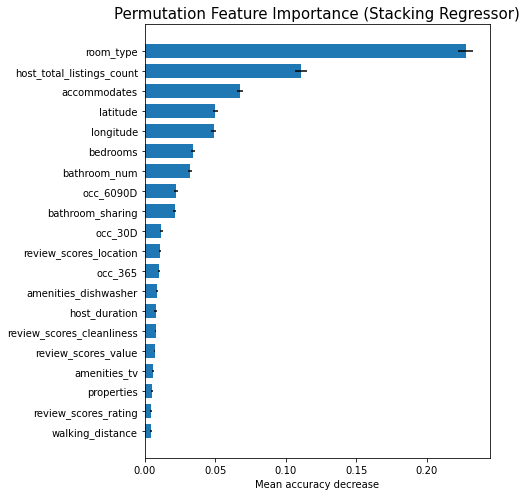

In [ ]:
# Visualize feature importances
pi_top20 = pi[0:20]
name = 'Stacking Regressor'
fig, ax = plt.subplots(figsize=[7,7])
plt.barh(y = pi_top20['feature_names'], width = pi_top20['feature_impt'], xerr=pi_top20['std'], height = 0.7)
ax.set_title("Permutation Feature Importance ({})".format(name), fontsize = 15)
ax.set_xlabel("Mean accuracy decrease")
ax.invert_yaxis()  # labels read top-to-bottom
fig.tight_layout()
plt.show()

### SHAP Values

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(lgbm_best.named_steps["regressor"])
shap_values = explainer.shap_values(lgbm_best[:-1].transform(X_train))
np.shape(shap_values)

(26408, 719)

In [ ]:
all_features = list(num_cols)+list(lgbm_best.named_steps['preprocess'].named_transformers_['cat'].get_feature_names_out(cat_cols))
X_train_preprocessed = preprocessor.transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = all_features)
print(np.shape(X_train_preprocessed))

AttributeError: 'Pipeline' object has no attribute 'get_feature_names_out'

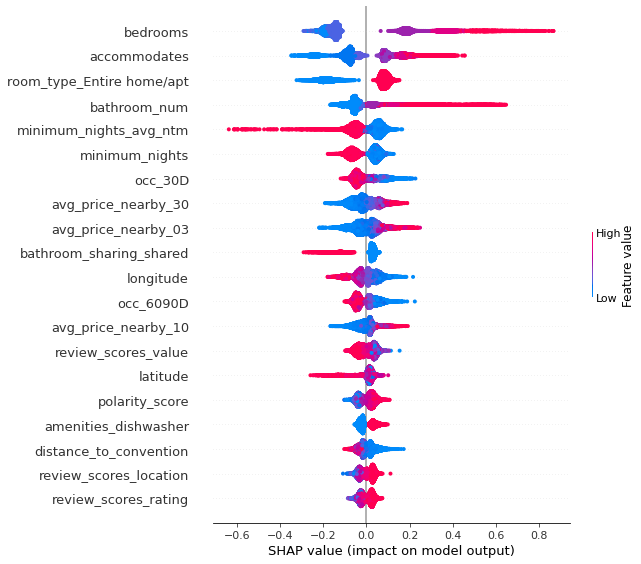

In [ ]:
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_preprocessed)
plt.show()

### Neural Network SHAP

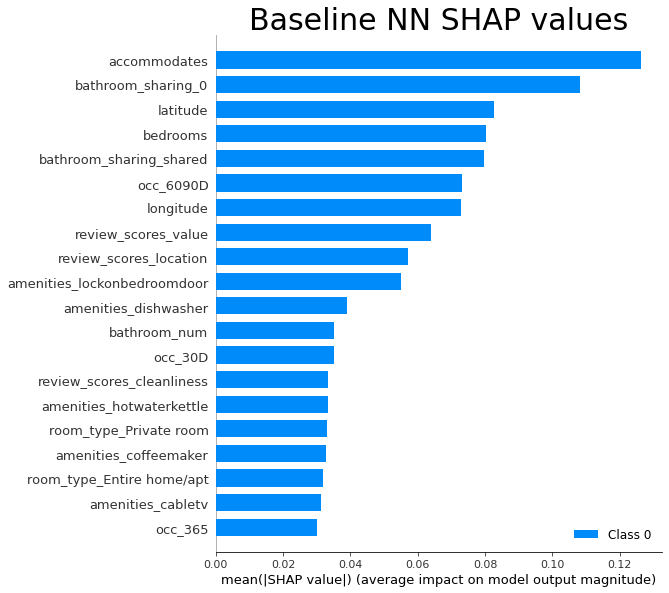

In [ ]:
explainer = shap.DeepExplainer(best_model_bl,X_train_trfm[:100])
shap_values = explainer.shap_values(X_train_trfm.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_trfm, show=False)
plt.title("Baseline NN SHAP values",size=30)
plt.show()

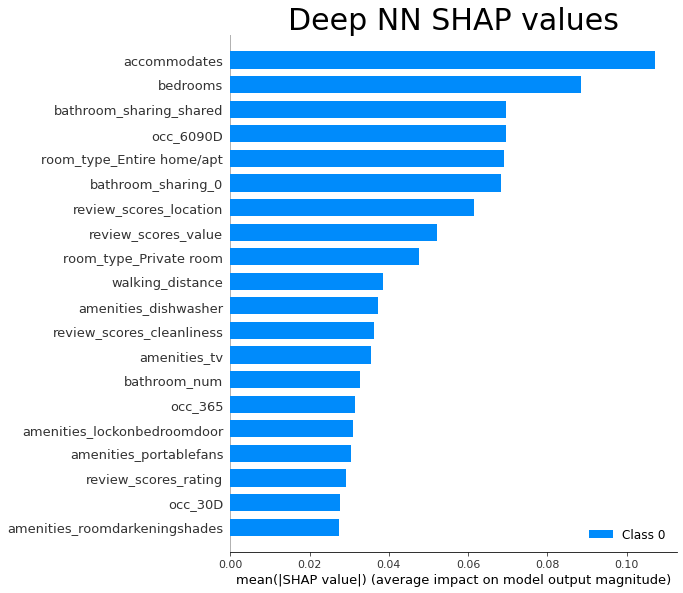

In [ ]:
explainer = shap.DeepExplainer(best_model_dp,X_train_trfm[:100])
shap_values = explainer.shap_values(X_train_trfm.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_trfm, show=False)
plt.title("Deep NN SHAP values",size=30)
plt.show()

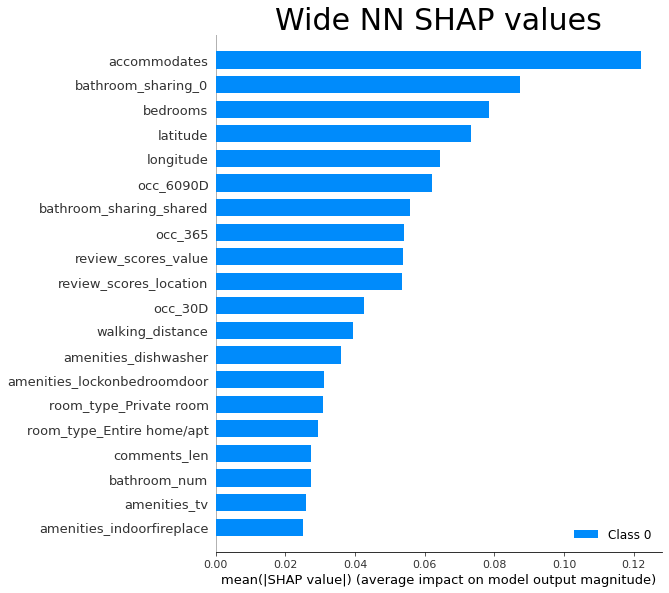

In [ ]:
explainer = shap.DeepExplainer(best_model_wd,X_train_trfm[:100])
shap_values = explainer.shap_values(X_train_trfm.values)
plt.figure(figsize = (8,5))
shap.summary_plot(shap_values, X_train_trfm, show=False)
plt.title("Wide NN SHAP values",size=30)
plt.show()

### Actual vs Predicted

In [ ]:
import matplotlib.cm as cm
sns.set_style("whitegrid")

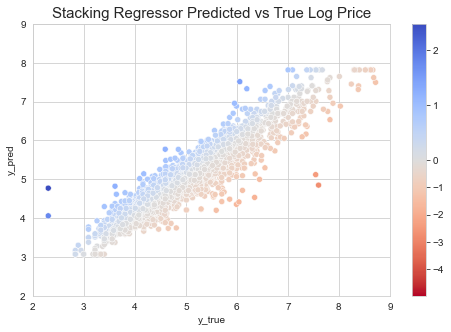

In [ ]:
stacking_regressor_best.fit(X_train, y_train)
pred = stacking_regressor_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Stacking Regressor Predicted vs True Log Price', fontsize = 15)
plt.show()

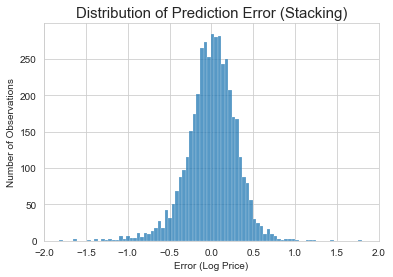

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Stacking)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

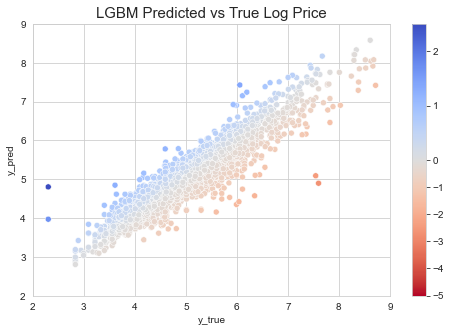

In [ ]:

lgbm_best.fit(X_train, y_train)
pred = lgbm_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('LGBM Predicted vs True Log Price', fontsize = 15)
plt.show()

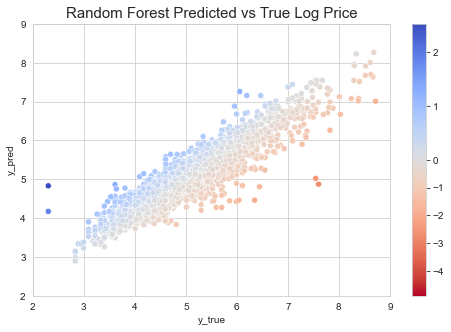

In [ ]:
rf_best.fit(X_train, y_train)
pred = rf_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Random Forest Predicted vs True Log Price', fontsize = 15)
plt.show()

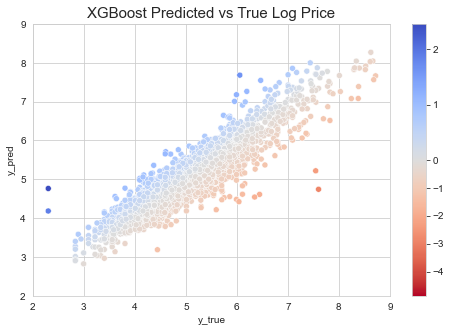

In [ ]:
xgb_best.fit(X_train, y_train)
pred = xgb_best.predict(X_test)
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('XGBoost Predicted vs True Log Price', fontsize = 15)
plt.show()

### Neural Network Actual VS Predicted

In [ ]:
import matplotlib.cm as cm
sns.set_style("whitegrid")
import matplotlib.colors as mcolors

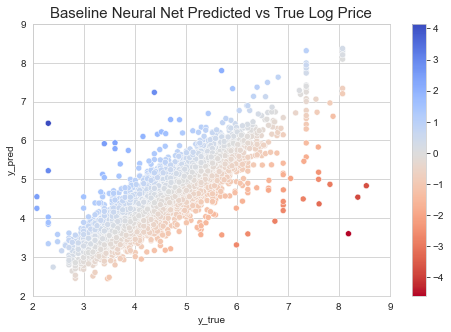

In [ ]:
pred = best_model_bl.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Baseline Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

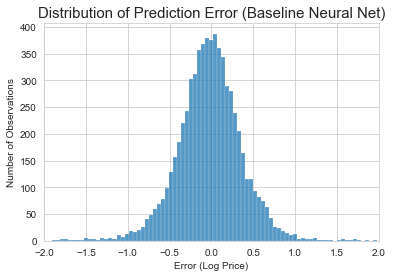

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Baseline Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

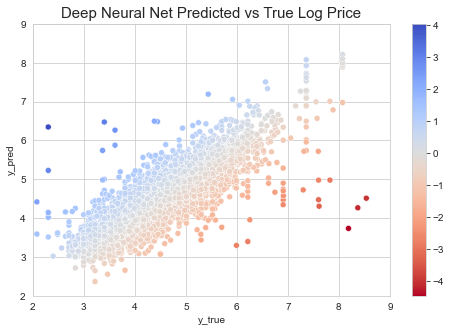

In [ ]:
pred = best_model_dp.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Deep Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

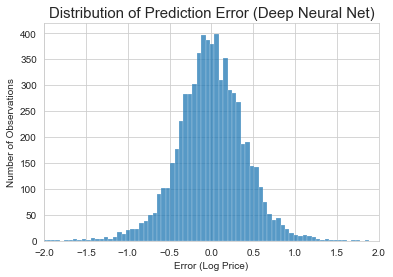

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Deep Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()

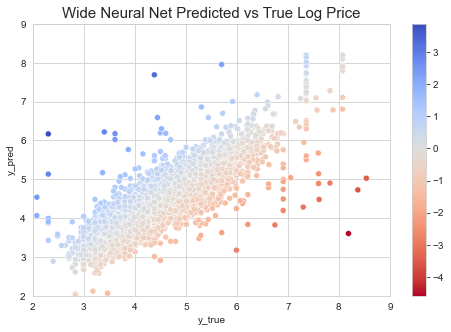

In [ ]:
pred = best_model_wd.predict(X_test_trfm)[:,0]
df_pred = pd.DataFrame.from_dict({'y_pred': pred, 'y_true': y_test})
df_pred['deviation'] = df_pred['y_pred'] - df_pred['y_true']

# Get/set params for the colour mapping
vcenter = 0
vmin, vmax = df_pred['deviation'].min(), df_pred['deviation'].max()
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
colormap = cm.coolwarm_r

plt.figure(figsize = (8,5))
sns.scatterplot(x = 'y_true', y = 'y_pred', data = df_pred,  
                cmap=colormap, c=df_pred['deviation'], norm=normalize)

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df_pred['deviation'])
plt.colorbar(scalarmappaple)
plt.ylim(2,9)
plt.xlim(2,9)
plt.title('Wide Neural Net Predicted vs True Log Price', fontsize = 15)
plt.show()

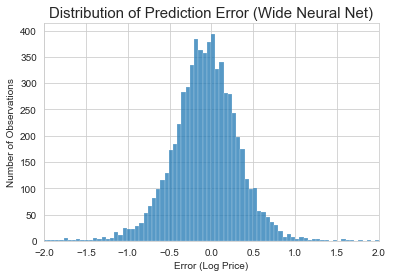

In [ ]:
sns.histplot(df_pred['deviation'])
plt.xlabel('Error (Log Price)')
plt.ylabel('Number of Observations')
plt.title('Distribution of Prediction Error (Wide Neural Net)', fontsize = 15)
plt.xlim(-2, 2)
plt.show()